## 超解像をやってみる

超解像という問題を deep learning で解いてみます。

解像度の低い画像を入力に、解像度が高い画像を出力できるようなニューラルネットワークがほしい、という問題です。

今回は簡単にためすために、小さい画像でこの問題を解いてみます。

まずは fashion mnist というデータセットを読み込みます。この画像データは MNIST と同じく 28x28x1 というサイズの画像です。

これをあえて 7x7 に resize したデータを入力にし、28x28 の元画像を復元できるように学習していきます。

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from scipy.misc import imresize

(original_images, _), (test_original_images, _) = tf.keras.datasets.fashion_mnist.load_data()

# 28x28 → 7x7 に縮小します。これが学習データの入力になります。

def resize_images(images):
  resized_images = np.zeros([original_images.shape[0], 7, 7, 1])
  for i, img in enumerate(images):
      resized_images[i, :, :, 0] = imresize(img.reshape((28, 28)), (7, 7))
  return resized_images

reshaped_original_images = np.expand_dims(original_images, axis=-1)
resized_images = resize_images(reshaped_original_images)

# 0~255 を 0~1.0 の範囲に変換しておきます
reshaped_original_images = reshaped_original_images.astype('float32') / 255.0
resized_images = resized_images.astype('float32') / 255.0

print("original images: ", reshaped_original_images.shape)
print("resized images: ", resized_images.shape)

# Validation 用の画像も準備しておきます。

reshaped_test_original_images = np.expand_dims(test_original_images, axis=-1)
test_resized_images = resize_images(reshaped_test_original_images)

# 0~255 を 0~1.0 の範囲に変換しておきます
reshaped_test_original_images = reshaped_test_original_images.astype('float32') / 255.0
test_resized_images = test_resized_images.astype('float32') / 255.0

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


original images:  (60000, 28, 28, 1)
resized images:  (60000, 7, 7, 1)


Original


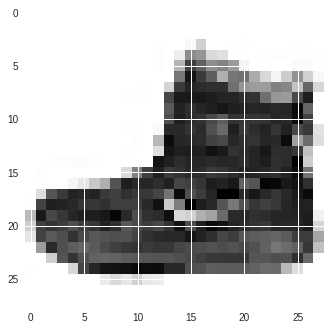

Resized


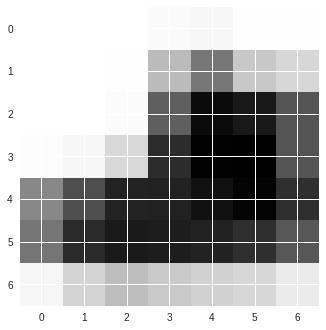

In [2]:
print('Original')
plt.imshow(original_images[0])
plt.show()
print('Resized')
plt.imshow(resized_images[0].reshape((7, 7)))
plt.show()

## モデル例

7x7x1 を入力にするので、最初は

```python
from tensorflow.python.keras.layers import Input
input = Input(shape=(7, 7, 1))
```

になります。  
これをいくつかの Layer に通して 28x28x1 の出力を得ることが目標です。

`Conv2D ` は、入力のサイズを小さくしてしまう方向の演算ですが、今回は画像サイズを大きくしなければならないので、`UpSampling2D` を使います。

In [3]:
from tensorflow.python.keras.layers import Input, UpSampling2D

input = Input(shape=(7, 7, 1))
UpSampling2D()(input)

<tf.Tensor 'up_sampling2d/ResizeNearestNeighbor:0' shape=(?, 14, 14, 1) dtype=float32>


`UpSampling2D` は各ピクセルを単純に 2 回ずつ繰り返すことで、画素数を 2x2 倍にする層です。  
単に繰り返すだけなので、学習の余地はありません。

そこで、`Conv2D` と `UpSampling2D` を交互に繰り返すことで、学習担当は `Conv2D`、拡大する仕事は `UpSampling2D` に担ってもらいます。

↓に活性化関数なども加えた、典型的なモデル例を書いてみます。

In [4]:
from tensorflow.python.keras.layers import Input, Conv2D, BatchNormalization, Activation, UpSampling2D

def create_model():
  input = tf.keras.layers.Input(shape=(7, 7, 1))
  x = Conv2D(64, kernel_size=3, padding='same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2D(64, kernel_size=3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2D(64, kernel_size=3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(1, kernel_size=3, padding='same')(x)
  output = Activation('sigmoid')(x)
  return tf.keras.Model(input, output)

create_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 7, 7, 1)           0         
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 64)          640       
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 64)          256       
_________________________________________________________________
activation (Activation)      (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
__________

入力 7x7x1 → 出力 28x28x1 になっていることを確認してください。

今回のモデルは最後に `sigmoid` という活性化関数を通しています。これは、 -∞ ~ +∞ までの値を 0~1 に変換する関数です。

先程画像を 255.0 で割ることで、正解データの各ピクセルの値を 0~1 の範囲に限定しました。  
なので出力も 0~1 の範囲に揃えてあげます。

実際に学習してみます。
ちょっと時間がかかるので 1 周（1 epoch）だけ学習させます。(optimizer を adam というものにしました。他にもいろいろあるので試してみてください。収束のはやさなどが変わってきます。)

In [5]:
model = create_model()
model.compile('adam', loss='mean_squared_error', metrics=['mean_squared_error']) # 「各 pixel の値が正解のピクセルとどれだけずれているか」が損失

model.fit(x=resized_images, y=reshaped_original_images, batch_size=64, epochs=1)

Epoch 1/1
60000/60000 [==============================] - 22s 368us/step - loss: 0.0128 - mean_squared_error: 0.0128


今回の損失関数は `mean_squared_error` にしました。  
これは、 `(正解の値 - 予測値) ^ 2` の和です。

最高の出力をできた場合は `正解の値 - 予測値 == 0` なのでこの損失は 0 になります。  

学習結果を表示してみましょう。validation の画像を使います。

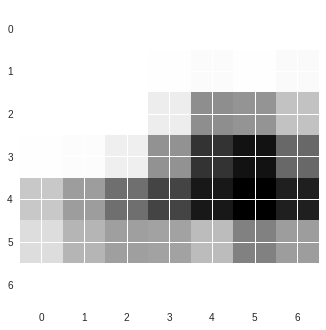

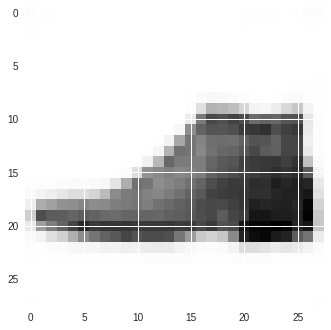

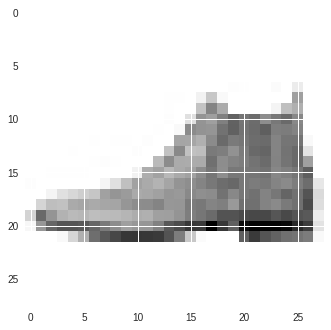

In [6]:
def show(img, size=(28, 28)):
  img = img * 255.0
  plt.imshow(img.astype('uint8').reshape(size))
  plt.show()

original = reshaped_test_original_images[0]
resized = test_resized_images[0]
pred = model.predict(np.array([resized]))

show(resized, size=(7, 7))
show(pred)
show(original)

元画像が小さいのでちょっとわかりにくいかもしれませんが、それなりに予測できていそうです。

今回は時間の都合もあって、小さい画像データを取り扱いましたが、データサイズが大きくなっても同じ構造で超解像が実現できます。（もちろん大きい画像データのほうがより難しく、さまざまな工夫が研究されています。）